In [1]:
# Instructions for submission

# 1. Rename this file to groupXX_PPGHR.ipynb where XX is your group number as visible in the Google spreadsheet
# 2. State the team members (e-mail, legi):
# example@student.ethz.ch, XX-YYY-ZZZ
# TO BE FILLED
# TO BE FILLED
# 3. Kaggle team name: TO BE FILLED
# 4. Upload this file in a zipped folder together with your final predictions to the provided Polybox link. See the Submission section in the PDF for more details.

In [198]:
# Import necessary libraries
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from scipy import fftpack
%matplotlib widget

In [3]:
import os
current_directory = os.getcwd()
relative_path = "kaggle/input/24-exercise1/mhealth24_data_public.npy"
full_path = os.path.join(current_directory, relative_path)

In [188]:
sampling_rate = 128  # Hz
# Load data item containing the PPG, HR, and IMU signals from all phases
data = np.load(full_path, allow_pickle=True).item() # now it is a dict

#print('Keys for data:', data.keys())

# Example to extract the data from phase 0
phase0_data = data['phase 0']
phase1_data=data['phase 1']
phase2_data=data['phase 2']
phase3_data=data['phase 3']
phase4_data=data['phase 4']
phase5_data=data['phase 5']

# Get the individual signals from phase 0
ppg_phase0 = phase0_data['PPG wrist']
ppg_phase2= phase2_data['PPG head']
ppg_phase4= phase4_data['PPG head']

# Concatenate the data from ppg_phase0, ppg_phase2, and ppg_phase4
ppg_all_traning_data = np.concatenate((ppg_phase0, ppg_phase2, ppg_phase4))

#HR
ref_hr_phase0 = phase0_data['ground truth HR']  # only available for phase 0, 2, and 4 (training data)
ref_hr_phase2 = phase2_data['ground truth HR']
ref_hr_phase4 = phase4_data['ground truth HR']
ref_hr_phase_all = np.concatenate((ref_hr_phase0, ref_hr_phase2, ref_hr_phase4))

# X 
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_X_phase2 = phase2_data['IMU X head']
IMU_X_phase4 = phase4_data['IMU X head']
IMU_X_all = np.concatenate((IMU_X_phase0, IMU_X_phase2, IMU_X_phase4))

# Y
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Y_phase2 = phase2_data['IMU Y head']
IMU_Y_phase4 = phase4_data['IMU Y head']
IMU_Y_all = np.concatenate((IMU_Y_phase0, IMU_Y_phase2, IMU_Y_phase4))

# Z
IMU_Z_phase0 = phase0_data['IMU Z wrist']
IMU_Z_phase2 = phase2_data['IMU Z head']
IMU_Z_phase4 = phase4_data['IMU Z head']
IMU_Z_all = np.concatenate((IMU_Z_phase0, IMU_Z_phase2, IMU_Z_phase4))


#All IMU 
IMU_all=np.array([IMU_X_all,IMU_Y_all,IMU_Z_all]).T

Functions

In [258]:
import numpy as np
# Function to plot any signal with time on the x-axis

def plot_signal(signal1, title='Signal', ylabel='time', sampling_rate=128):
    x = np.linspace(0, np.shape(signal1)[0] / sampling_rate, len(signal1))
    t = pd.to_datetime(x, unit='s')
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 6))
    if len(np.shape(signal1))>1:
        for i in range(np.shape(signal1)[1]):
            ax1.plot(x/(30), signal1[:,i])
            
    else: 
        peak_postions=get_peaks(signal1)
        ax1.plot(t, signal1)
        ax1.plot(t[peak_postions], signal1[peak_postions], 'ro')  
        ax1.set_xlabel('Time [min:sec]')
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
  
    ax1.set_title(title)
    ax1.set_ylabel(ylabel)

    xf,yf=frequency_spectrum(signal1,sampling_rate)
    ax2.plot(xf, yf)
    ax2.set_title('Frequency spectrum')
    ax2.set_xlabel('Frequency [Hz]')

    
    plt.show()

#sktime
# filter out the problem areas with accelermometer 
    # plot a slider in the final graph for the diffrent thresholds to be able to easy manipulate them   pr make palne with the diffrent parameters and the erro as function value and minimizet that  
def filter_signal(sig, lowHR, highHR, sampling_rate):
    low=lowHR/60
    high=highHR/60
    sos = signal.butter(3, [low,high], 'bandpass', fs=sampling_rate, output='sos')
    if len(np.shape(sig))>1:
        filtered_signal=np.zeros(np.shape(sig))
        for i in range(np.shape(sig)[1]):
            filtered_signal[:,i] = signal.sosfilt(sos, sig[:,i])
    else:       
        filtered_signal = signal.sosfilt(sos, sig)
    return filtered_signal


def frequency_spectrum(sig, sampling_rate):
    fft = fftpack.fft(sig)
    frequencies = np.fft.fftfreq(len(sig), 1/sampling_rate)
    return frequencies[:len(fft)//2], np.abs(fft[:len(fft)//2])



def get_bpm_with_highest_amplitude(signal, sampling_rate):
    # Compute the Fast Fourier Transform (FFT) of the signal
    fft = np.fft.fft(signal)
    # Compute the frequencies corresponding to the FFT
    frequencies = np.fft.fftfreq(len(signal), 1/sampling_rate)
    # Find the index of the maximum amplitude in the FFT result
    max_amplitude_index = np.argmax(np.abs(fft))
    # Get the frequency with the highest amplitude
    frequency_with_highest_amplitude = frequencies[max_amplitude_index]
    return frequency_with_highest_amplitude*60

def get_bpm_with_count_peaks(signal_1d,duration=30):
    peakpostions=get_peaks(signal_1d)#,height=heigth_of_peak,distance=(lowHR/60)*sampling_rate)) #(highHR/60)*sampling_rate]))
    return  len(peakpostions)*(60/duration)

def get_bpm_with_measure_distance_beetweens_peaks(signal_1d,sampling_rate=128):
    peak_postions=get_peaks(signal_1d)
    distance_beetween_peaks=peak_postions[1:]-peak_postions[:-1]
    return 60/(np.mean(distance_beetween_peaks)/sampling_rate)

def get_peaks(sig,distance=(60/180),sampling_rate=128,height=None,threshold=None):# height=[1000,10**5]
    distance_samples=distance*sampling_rate
    peaks_positions,empty=(signal.find_peaks(sig,distance=distance_samples,threshold=threshold,height=height))
    return peaks_positions

def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    print("Resulting score {:4.3f}".format(0.5 * np.mean(err) + 0.5 * np.median(err)))
    
def get_intervall(sig,intervall,window_size_sec=30,sampling_rate=128):
    if len(np.shape(sig))>1:
        return sig[intervall[0]*window_size_sec*sampling_rate:intervall[1]*window_size_sec*sampling_rate,:]
    return sig[intervall[0]*window_size_sec*sampling_rate:intervall[1]*window_size_sec*sampling_rate]



Filter the signal

Create Test signal

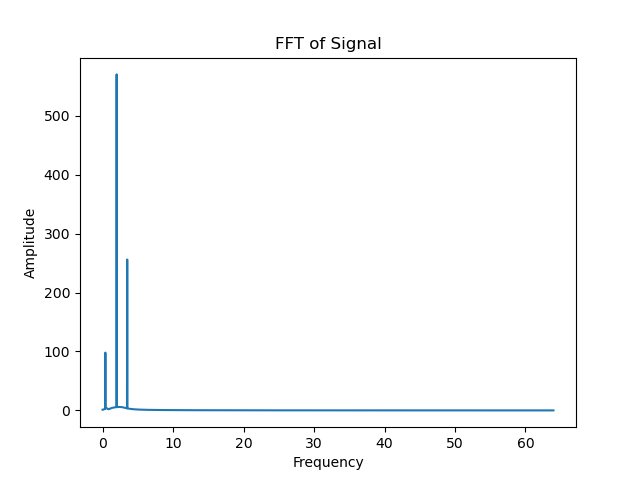

In [237]:
import numpy as np

# Define the parameters
duration = 30  # seconds
sampling_rate = 128  # Hz
frequencies = [2, 0.4, 3.5]  # Hz
amplitudes = [0.3, 0.4, 0.7]  # a.u.

# Calculate the number of samples
num_samples = int(duration * sampling_rate)

# Generate the time axis
time = np.arange(num_samples) / sampling_rate

# Generate the signal
test_signal = amplitudes[0]*np.sin(2 * np.pi * frequencies[0] * time) + amplitudes[1]*np.sin(2 * np.pi * frequencies[1] * time) + amplitudes[0]*np.sin(2 * np.pi * frequencies[2] * time)
test_signal_filtred=filter_signal(test_signal,40,180,128)

plt.figure()
x,y=frequency_spectrum(test_signal_filtred, 128)
# Plot the frequencies and the absolute values of the FFT
plt.plot(x,y)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('FFT of Signal')
plt.show()


(3260160, 3)


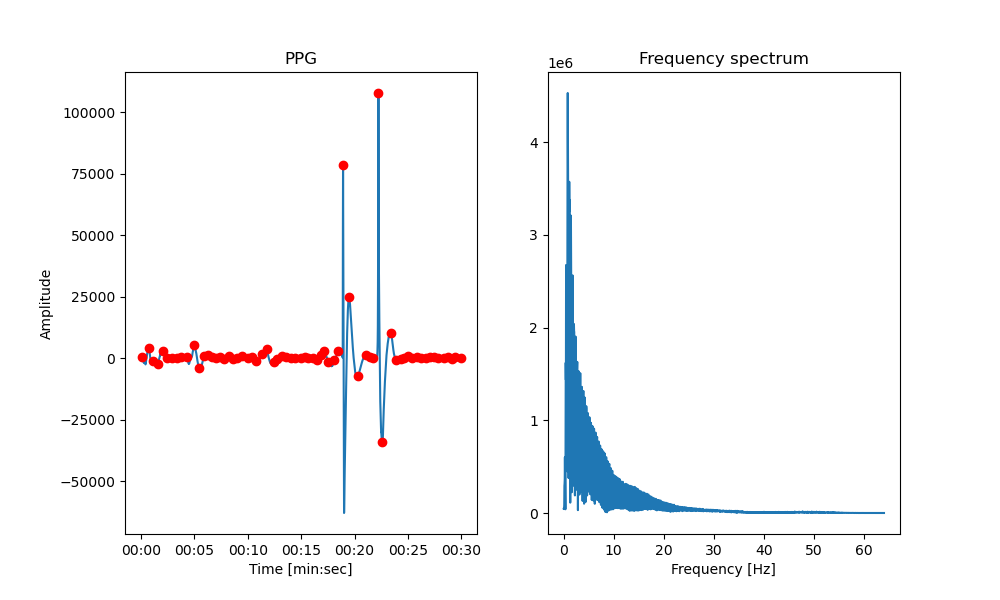

136.0
134.34986945169712
[73.38842975]


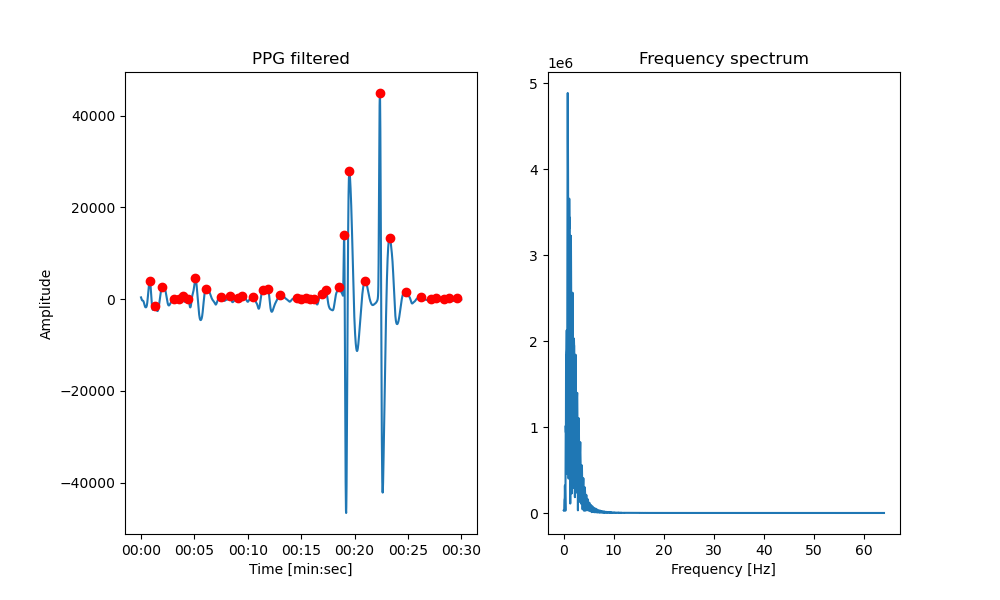

74.0
75.11002444987776
[73.38842975]


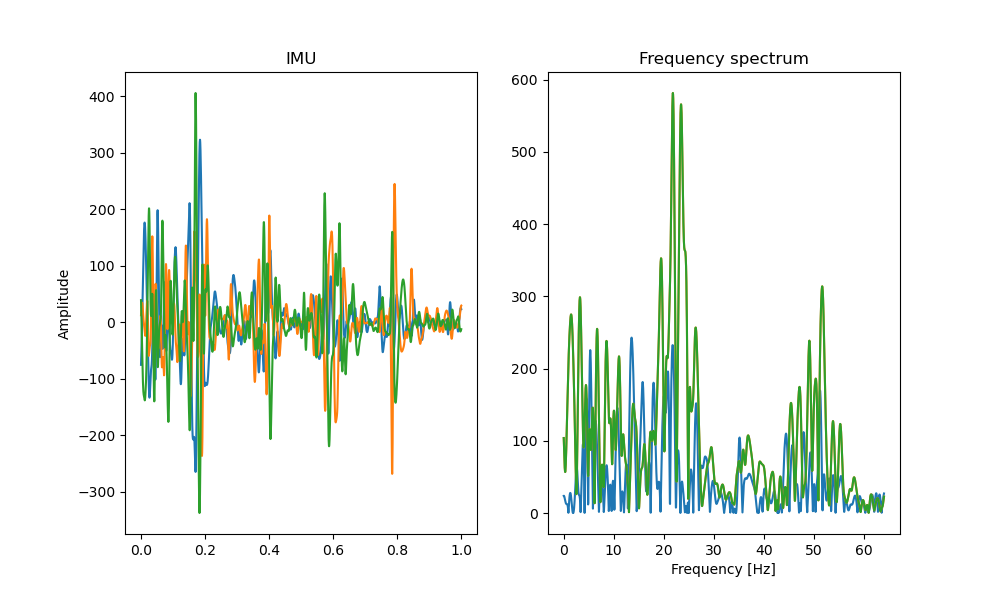

In [268]:
intervall=[100,101]

#PROBLEM Area [100,300]

signal_filtered=filter_signal(ppg_all_traning_data,40,180,128)
signal_HP_filtered=filter_signal(ppg_all_traning_data,40,3000,128)
shown_signal=get_intervall(signal_HP_filtered,intervall)
shown_signal_filtered=get_intervall(signal_filtered,intervall)

IMU_all_filtered=filter_signal(IMU_all,40,180,128)
print(IMU_all_filtered.shape)
shown_IMU=get_intervall(IMU_all_filtered,intervall)


#subplot_signal(test_signal,test_signal_filtred, 'PPG wrist', 'Amplitude', 128)
plot_signal(shown_signal, 'PPG', 'Amplitude', 128)
print(get_bpm_with_count_peaks(shown_signal,duration=30*(intervall[1]-intervall[0])))
print(get_bpm_with_measure_distance_beetweens_peaks(shown_signal))
print(ref_hr_phase_all[intervall[0]:intervall[1]])

plot_signal(shown_signal_filtered, 'PPG filtered', 'Amplitude', 128)
print(get_bpm_with_count_peaks(shown_signal_filtered,duration=30*(intervall[1]-intervall[0])))
print(get_bpm_with_measure_distance_beetweens_peaks(shown_signal_filtered))
print(ref_hr_phase_all[intervall[0]:intervall[1]])


plot_signal(shown_IMU, 'IMU', 'Amplitude', 128)
%matplotlib widget


#plot_frequency_spectrum(filtered_signal_but, 128)
#print(get_bpm_with_highest_amplitude(filtered_signal_but, 128))

#plot_frequency_spectrum(test_signal_filtred, 128)
#print(get_bpm_with_highest_amplitude(test_signal_filtred, 128))




Calculate the avarage bpm value

heart rate ploted over a day

(849,)
(849,)


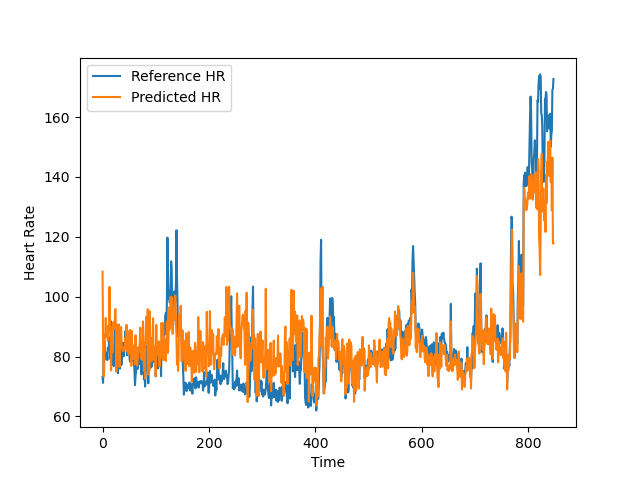

Mean error: 7.510, Median error 5.080
Resulting score 6.295


In [269]:
def get_bpm_over_time(signal,sampling_rate=128,sampling_time_signal=30,lowHR=40,highHR=180):
    bpms=np.zeros(int(np.floor(len(signal)/(sampling_time_signal*sampling_rate))))
    j=0
    for i in range(0, len(signal)-sampling_time_signal*sampling_rate, sampling_time_signal*sampling_rate):
        this_signal = butterworth_filter_signal(signal[i:i+sampling_time_signal*sampling_rate],lowHR,highHR,sampling_rate)
        bpms[j] = get_bpm_with_measure_distance_beetweens_peaks(this_signal,sampling_rate)
        j+=1
    return bpms

#filtred_signal_but_full= butterworth_filter_signal(ppg_phase0,40,180,128)

pred_hr=get_bpm_over_time(phase_all_traning_data,sampling_time_signal=30)

pred_hr[-1]=pred_hr[-2]
print(pred_hr.shape)
print(ref_hr_phase_all.shape)
xTimes = np.arange(0, len(pred_hr))
plt.figure()
plt.plot(xTimes, ref_hr_phase_all, label='Reference HR')
plt.plot(xTimes, pred_hr, label='Predicted HR')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.legend()
plt.show()

# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle


# Example on how to use the print_score function with randomly generated HR values as the predictions
 #list(np.random.randint(40, 180, len(ref_hr_phase0)))
print_score(pred_hr, ref_hr_phase_all)


#xTimes=np.arange(0, len(predicted_bpms))
#plt.plot(xTimes,predicted_bpms)
#plt.show()

(3260160, 3)
2


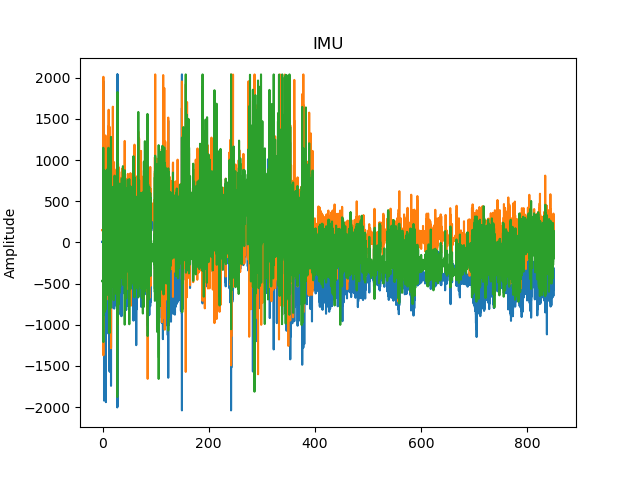

In [194]:
#plot the IMU data

plot_signal(IMU_all_filtered, 'IMU', 'Amplitude', 128)

In [21]:
# Function to print the mean and median absolute error between your predicted HR and the reference HR
# With this function, you can evaluate the resulting score that you would obtain on the public dataset
# with your predicted HR values on Kaggle
def print_score(pred_hr, ref_hr):
    err = np.abs(np.asarray(pred_hr) - np.asarray(ref_hr))
    print("Mean error: {:4.3f}, Median error {:4.3f}".format(np.mean(err), np.median(err)))
    print("Resulting score {:4.3f}".format(0.5 * np.mean(err) + 0.5 * np.median(err)))

# Example on how to use the print_score function with randomly generated HR values as the predictions
pred_hr_phase0 = list(np.random.randint(40, 180, len(ref_hr_phase0)))
print_score(pred_hr_phase0, ref_hr_phase0)

Mean error: 41.472, Median error 32.618
Resulting score 37.045


In [248]:
# For each phase, you should now have obtained a list of predicted HR values
# Below, we give an example of how you can produce the submission.csv file from your predicted HR values
# To demonstrate the format of the submission.csv file, we provide an example with randomly generated HR values
# For phase 0, 1, 2, and 3 you should each obtain 396 HR values
# For phase 4 and 5 you should each obtain 57 HR values
# IMPORTANT: You have to replace the following predicted HR values with your predicted HR values!
pred_hr_phase0 = list(np.random.randint(40, 180, 396))
pred_hr_phase1 = list(np.random.randint(40, 180, 396))
pred_hr_phase2 = list(np.random.randint(40, 180, 396))
pred_hr_phase3 = list(np.random.randint(40, 180, 396))
pred_hr_phase4 = list(np.random.randint(40, 180, 57))
pred_hr_phase5 = list(np.random.randint(40, 180, 57))

# You can keep the below code unchanged to produce the submission.csv file
pred_hr_phases = [pred_hr_phase0, pred_hr_phase1, pred_hr_phase2,
                  pred_hr_phase3, pred_hr_phase4, pred_hr_phase5]
ids = []
pred_hr_flattened = []

for phase_counter in range(len(pred_hr_phases)):
    for hr_counter in range(len(pred_hr_phases[phase_counter])):
        pred_hr_flattened.append(pred_hr_phases[phase_counter][hr_counter])
        ids.append(f'phase{phase_counter}_{hr_counter}')


relative_path_result = "/kaggle/working/submission.csv"
full_path_result = os.path.join(current_directory, relative_path)
# If you use Kaggle, on the right side in tab "Output", you should now see a file called "submission.csv" after pressing "refresh"
# Download the file and submit it to the competition on Kaggle to obtain a score on the leaderboard for your team
df = pd.DataFrame({'Id': ids, 'Predicted': pred_hr_flattened})
df.to_csv(full_path_result, index=False)